----
**Author:** Gosaye Emshaw  
**Date:** 10/7/2025  

----

----
# 1. Introduction & Problem Statement

----
Pulsars are tiny, super-dense stars that spin very fast and send out beams of energy like a lighthouse. They’re made when big stars explode and collapse into a small core. As they spin, their beams sweep across space, and if the beam points toward Earth, we see regular flashes of light. Scientists study pulsars because they help us understand space, gravity, and even time.

----


In this project, we aim to develop a machine learning classifier that can determine whether a given celestial object is a pulsar or not. Pulsars are highly magnetized, rotating neutron stars that emit beams of electromagnetic radiation. Detecting them accurately is crucial for astrophysical research, including gravitational wave studies, galactic mapping, and testing fundamental physics.

Our model will be trained on a dataset containing eight key features extracted from radio signals observed by astronomers. These features represent measurable properties of the star, such as signal strength, dispersion, and profile shape, each offering clues about whether the object exhibits pulsar-like behavior.

By feeding these features into our classifier, scientists and astronomers can automate the process of identifying pulsars, reducing manual effort and improving detection accuracy. The final output will be a binary label: 1 for pulsar, 0 for non-pulsar, enabling faster cataloging and deeper analysis of stellar objects.

----
You can find the dataset here from [kaggle pulsar dataset](https://www.kaggle.com/datasets/charitarth/pulsar-dataset-htru2).

----

Pulsar detection is a time- and resource-intensive task. Each false detection can lead to wasted telescope time, misallocated funding, and misleading scientific conclusions. Therefore, our success depends on striking a careful balance between:

- **Maximizing true pulsar detections**
- **Minimizing false positives (non-pulsars misclassified as pulsars)**

To reflect this balance, we define the following performance metrics:

**Evaluation Criteria**

- **Primary Metric: F1-Score > 0.85**  
  Ensures a strong balance between precision and recall, especially important when both false positives and false negatives are costly.

- **Secondary Metric: Precision > 90%**  
  Prioritizes minimizing false positives—critical for avoiding misclassification of non-pulsars as pulsars.

- **Tertiary Metric: Recall > 85%**  
  Ensures we detect a high proportion of actual pulsars, reducing the risk of missing valuable discoveries.

These thresholds guide our model selection, tuning, and validation process to ensure scientific reliability and practical efficiency.

----
# 2. Data Loading & First Look

----
Before building our pulsar classifier, we need to load the dataset and explore its structure. This helps us understand the types of data we're working with and prepare for preprocessing and modeling.


**Goals of This Step**

- Load the dataset into a Pandas DataFrame
- Inspect the first few rows using `.head()`
- Check column names, data types, and missing values


## 2.1 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import (
precision_score, recall_score,
f1_score, precision_recall_curve,
roc_curve
)

## 2.2 Load the data

In [2]:
print("Loading the pulsar dataset...")
column_names = [
    "Mean_IP", "SD_IP", "EK_IP", "SK_IP", 
    "Mean_DMSNR", "SD_DMSNR", "EK_DMSNR", "SK_DMSNR", 
    "Target_Class"
]
try:
    pulsar = pd.read_csv("../data/raw/HTRU_2.csv", names = column_names)
    print("The pulsar dataset loaded successfully!")
except Exception as e:
    print(f"Loading failed: {e}")

Loading the pulsar dataset...
The pulsar dataset loaded successfully!


## 2.3 Basic Information

In [3]:
print("Displaying basic information of the pulsar dataset...")
print(f"* Shape: {pulsar.shape}")
print(f"\n* Data types: \n{pulsar.dtypes}")
print(f"\n* First 5 rows: \n{pulsar.head()}")
print(f"\n* Last 5 rows: \n{pulsar.tail()}")

Displaying basic information of the pulsar dataset...
* Shape: (17898, 9)

* Data types: 
Mean_IP         float64
SD_IP           float64
EK_IP           float64
SK_IP           float64
Mean_DMSNR      float64
SD_DMSNR        float64
EK_DMSNR        float64
SK_DMSNR        float64
Target_Class      int64
dtype: object

* First 5 rows: 
      Mean_IP      SD_IP     EK_IP     SK_IP  Mean_DMSNR   SD_DMSNR  \
0  140.562500  55.683782 -0.234571 -0.699648    3.199833  19.110426   
1  102.507812  58.882430  0.465318 -0.515088    1.677258  14.860146   
2  103.015625  39.341649  0.323328  1.051164    3.121237  21.744669   
3  136.750000  57.178449 -0.068415 -0.636238    3.642977  20.959280   
4   88.726562  40.672225  0.600866  1.123492    1.178930  11.468720   

    EK_DMSNR    SK_DMSNR  Target_Class  
0   7.975532   74.242225             0  
1  10.576487  127.393580             0  
2   7.735822   63.171909             0  
3   6.896499   53.593661             0  
4  14.269573  252.567306      

## 2.4 Check for Issues

In [4]:
print("Checking for issues...")

print("\n*Missing Values")
print(pulsar.isnull().sum())

print("\n*Duplicated Rows")
print(pulsar.duplicated().sum())

Checking for issues...

*Missing Values
Mean_IP         0
SD_IP           0
EK_IP           0
SK_IP           0
Mean_DMSNR      0
SD_DMSNR        0
EK_DMSNR        0
SK_DMSNR        0
Target_Class    0
dtype: int64

*Duplicated Rows
0


----
We successfully loaded the dataset.

- The pulsar dataset contains 17898 data sample points
- Our dataset have 8 features and 1 target
  -  **Mean_IP:** Mean of the integrated profile.
  -  **SD_IP:** Standard deviation of the integrated profile.
  -  **EK_IP:** Excess kurtosis of the integrated profile.
  -  **SK_IP:** Skewness of the integrated profile
  -  **Mean_DMSNR:** Mean of the DM-SNR curve.
  -  **SD_DMSNR:** Standard deviation of the DM-SNR curve.
  -  **EK_DMSNR:** Excess kurtosis of the DM-SNR curve.
  -  **SK_DMSNR:** Skewness of the DM-SNR curve.
  -  **Target_Class:** Class
- There are no missed values or duplicated rows

----
# 3. Basic Statistics

----
The features of pulsar dataset all are numeric, so it is easy to basic statistics to each of features in detail. In this section we will generate a summary statistics using (df.describe()), Then we will build a statistics table that contains
- Range of each features
- skewness of each features
- standard deviation
- any suspicious values

In [5]:
print("Generating basic statistics summary...")
target = "Target_Class"
features = [col for col in pulsar.columns if col != target]
display(pulsar[features].describe())

print("\nBuilding statistics table...")
range_val = pulsar[features].max() - pulsar[features].min()
mean_val = pulsar[features].mean()
median_val = pulsar[features].median()
std_val = pulsar[features].std()
skewness_val = pulsar[features].skew()
negative_val = (pulsar[features] < 0).sum()
zero_val = (pulsar[features] == 0).sum()

stat_table = pd.DataFrame({
    "Range": range_val,
    "Mean": mean_val,
    "Median": median_val,
    "Skewness": skewness_val,
    "Standard_deviation": std_val,
    "Negatives": negative_val,
    "Zeros": zero_val
})
display(stat_table)

Generating basic statistics summary...


,Mean_IP,SD_IP,EK_IP,SK_IP,Mean_DMSNR,SD_DMSNR,EK_DMSNR,SK_DMSNR
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837



Building statistics table...


,Range,Mean,Median,Skewness,Standard_deviation,Negatives,Zeros
Mean_IP,186.804688,111.079968,115.078125,-1.375188,25.652935,0,0
SD_IP,74.006869,46.549532,46.947479,0.126641,6.843189,0,0
EK_IP,9.945533,0.477857,0.223240,3.638410,1.064040,3898,0
SK_IP,69.893508,1.770279,0.198710,5.181293,6.167913,6850,0
Mean_DMSNR,223.178930,12.614400,2.801839,3.683302,29.472897,0,0
SD_DMSNR,103.271778,26.326515,18.461316,1.894254,19.470572,0,0
EK_DMSNR,37.679114,8.303556,8.433515,0.441501,4.506092,574,0
SK_DMSNR,1192.977813,104.857709,83.064556,2.734514,106.514540,1139,0


Key takeaways:
- The features are in different scale
- some features have extreme ranges
- some features have extreme skewness

----
# 4. Target Variable Analysis 

----
In classification task the target varible is the one that determines our models, performance metrics and fine tuning. Analyzing the target varible is the critical part in EDA. In this section we will 
- Count class distribution
- Visualize imbalance
- Calculate Imbalence ratio

Analyzing target variable...

1. Count class distribution


,Count,Percentage (%)
Target_Class,,
Not-Pulsar,16259,90.842552
Pulsar,1639,9.157448



2. Visualize Imbalance


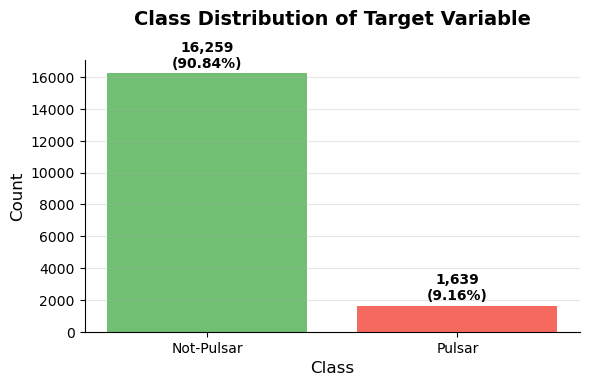


3. Imbalance ratio
Imbalance ratio: 0.10


In [6]:
import matplotlib.pyplot as plt

print("Analyzing target variable...")
print("\n1. Count class distribution")

count = pulsar[target].value_counts()
perct = (count / len(pulsar[target])) * 100

class_dist = pd.DataFrame({
    "Count": count,
    "Percentage (%)": perct
})

class_dist.index = class_dist.index.map({0: "Not-Pulsar", 1: "Pulsar"})
display(class_dist)

print("\n2. Visualize Imbalance")

plt.figure(figsize=(6, 4))
bars = plt.bar(class_dist.index, class_dist["Count"], color=["#4CAF50", "#F44336"], alpha=0.8)

plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Class Distribution of Target Variable", fontsize=14, weight="bold", y = 1.1)
plt.grid(True, axis='y', alpha=0.3)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


for i, (count_val, perc_val) in enumerate(zip(class_dist["Count"], class_dist["Percentage (%)"])):
    plt.text(
        i, count_val + (0.01 * max(class_dist["Count"])), 
        f"{count_val:,}\n({perc_val:.2f}%)",
        ha="center", va="bottom", fontsize=10, fontweight="bold"
    )
plt.savefig("../reports/figures/class_distribution_of_target_variable.png", dpi = 300, bbox_inches = "tight")
plt.tight_layout()
plt.show()

print("\n3. Imbalance ratio")
ratio = class_dist['Count'].min()/class_dist['Count'].max()
print(f"Imbalance ratio: {ratio:.2f}")

Key takeaways:
- Our target variable is highly imbalance
- Imbalance ratio = 0.1

----
# 5. Feature Distributions

----
Now let's seete distribution of each features. In this section we will visualize the distribution of the 8 features.


Visualizing feature distributions...


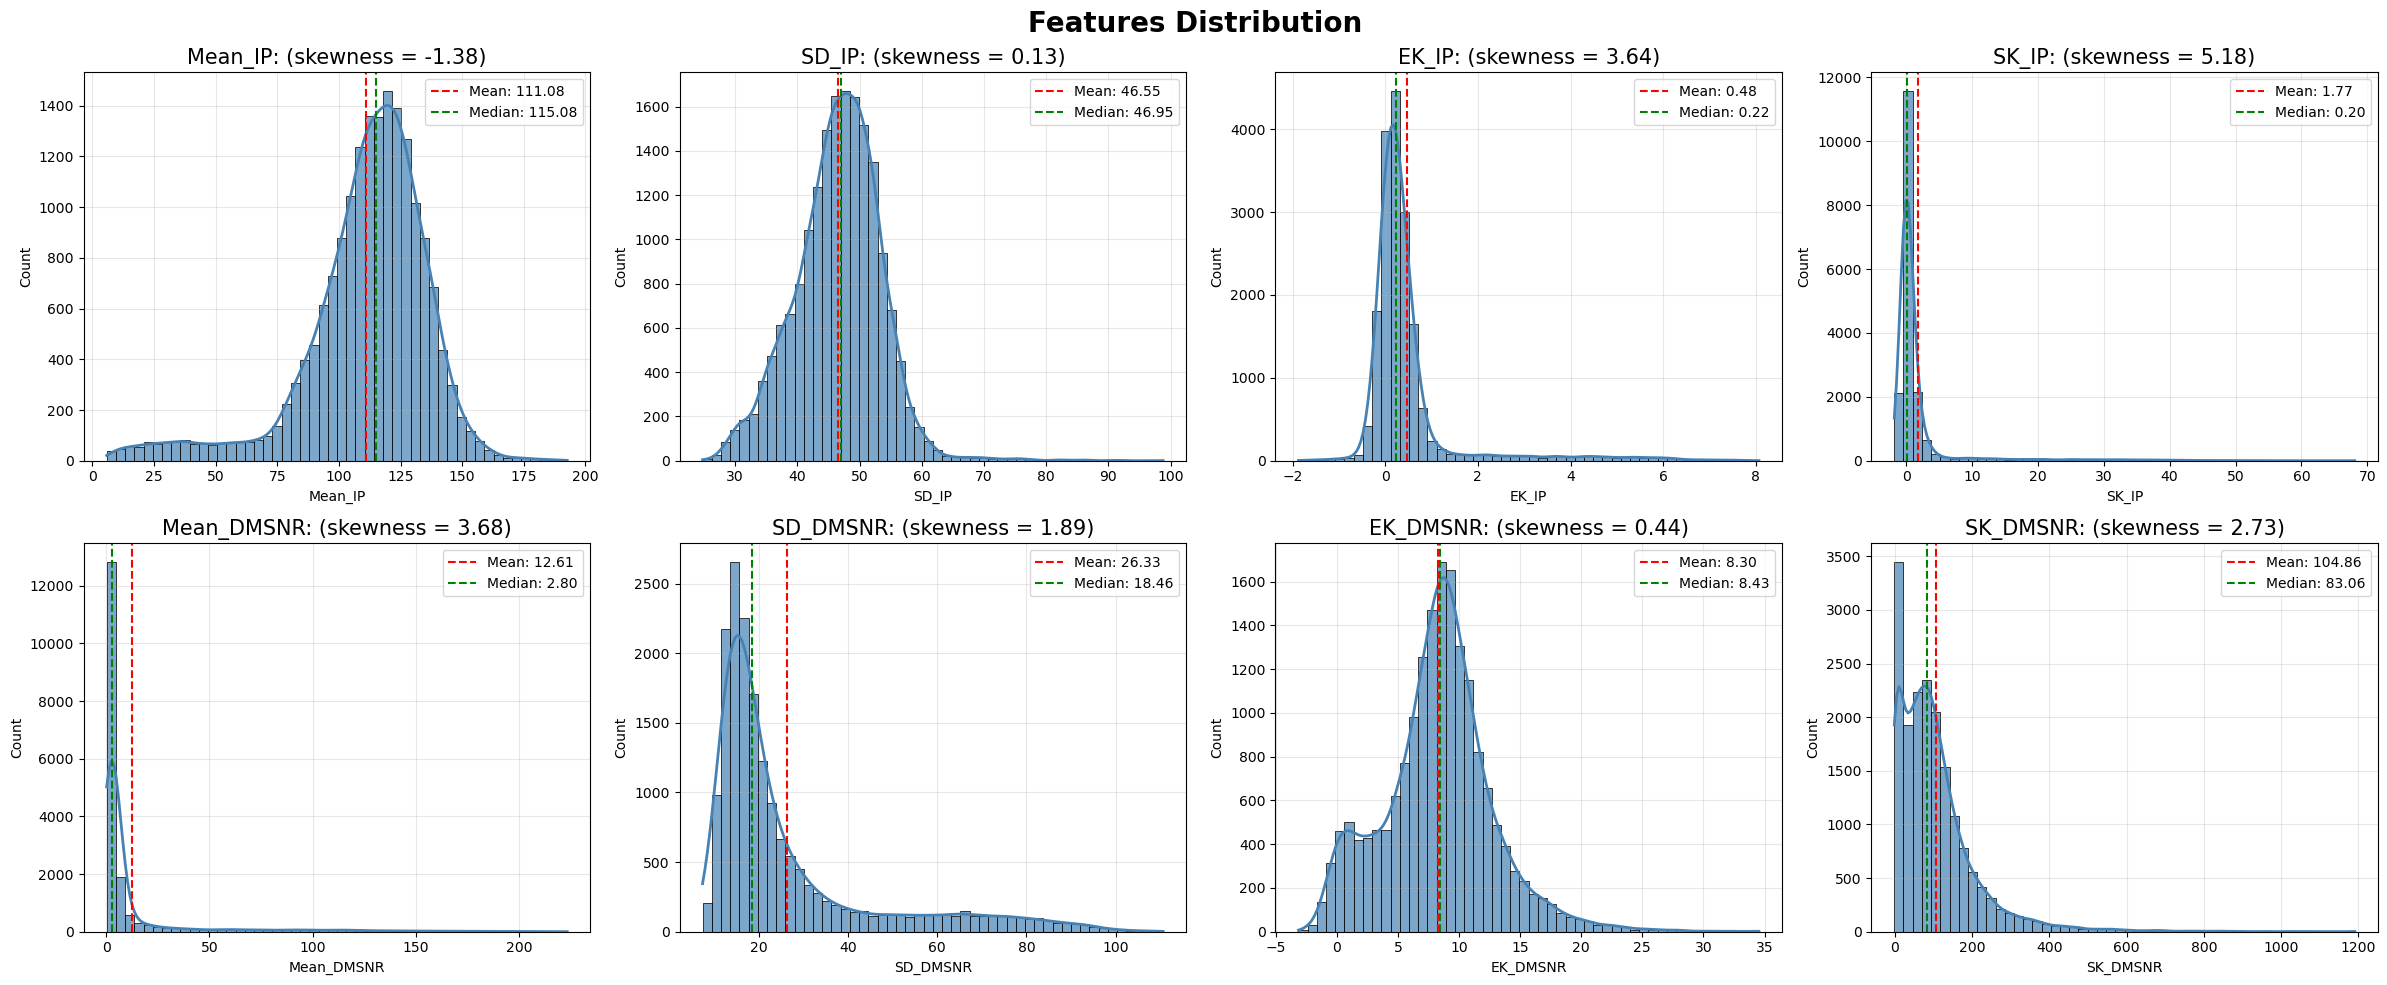

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Visualizing feature distributions...")

fig, axes = plt.subplots(2, 4, figsize=(24, 10))
fig.suptitle("Features Distribution", fontsize=20, fontweight='bold')

axes_flat = axes.flatten()

for i, feature in enumerate(features):
    mean = pulsar[feature].mean()
    median = pulsar[feature].median()
    skewness = pulsar[feature].skew()

    sns.histplot(data=pulsar, x=feature, kde=True, ax=axes_flat[i], bins=50,color='steelblue',edgecolor='black',
        alpha=0.7, line_kws={"color": "darkorange", "linewidth": 2} 
    )

    axes_flat[i].axvline(mean, color='red', linestyle="--", label=f"Mean: {mean:.2f}")
    axes_flat[i].axvline(median, color='green', linestyle="--", label=f"Median: {median:.2f}")

    axes_flat[i].set_title(f"{feature}: (skewness = {skewness:.2f})", fontsize=15)
    axes_flat[i].set_xlabel(feature)
    axes_flat[i].grid(True, alpha=0.3)
    axes_flat[i].legend()

plt.tight_layout()
plt.savefig("../reports/figures/features_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


key takeaways:
- Most features are extremely skewed to the right
- EX_DMSNR and SD_IP are the only near normal distibution features
- Except Mean_IP all other features are skewed to the right

----
# 6. Feature Distributions by Class 

----
The most important analysis in EDA is analysis of feature-target relationships. In this section we will:
- Plot distribution of features by class
- Extract insights from the plots

Visualizing feature distributions by class...


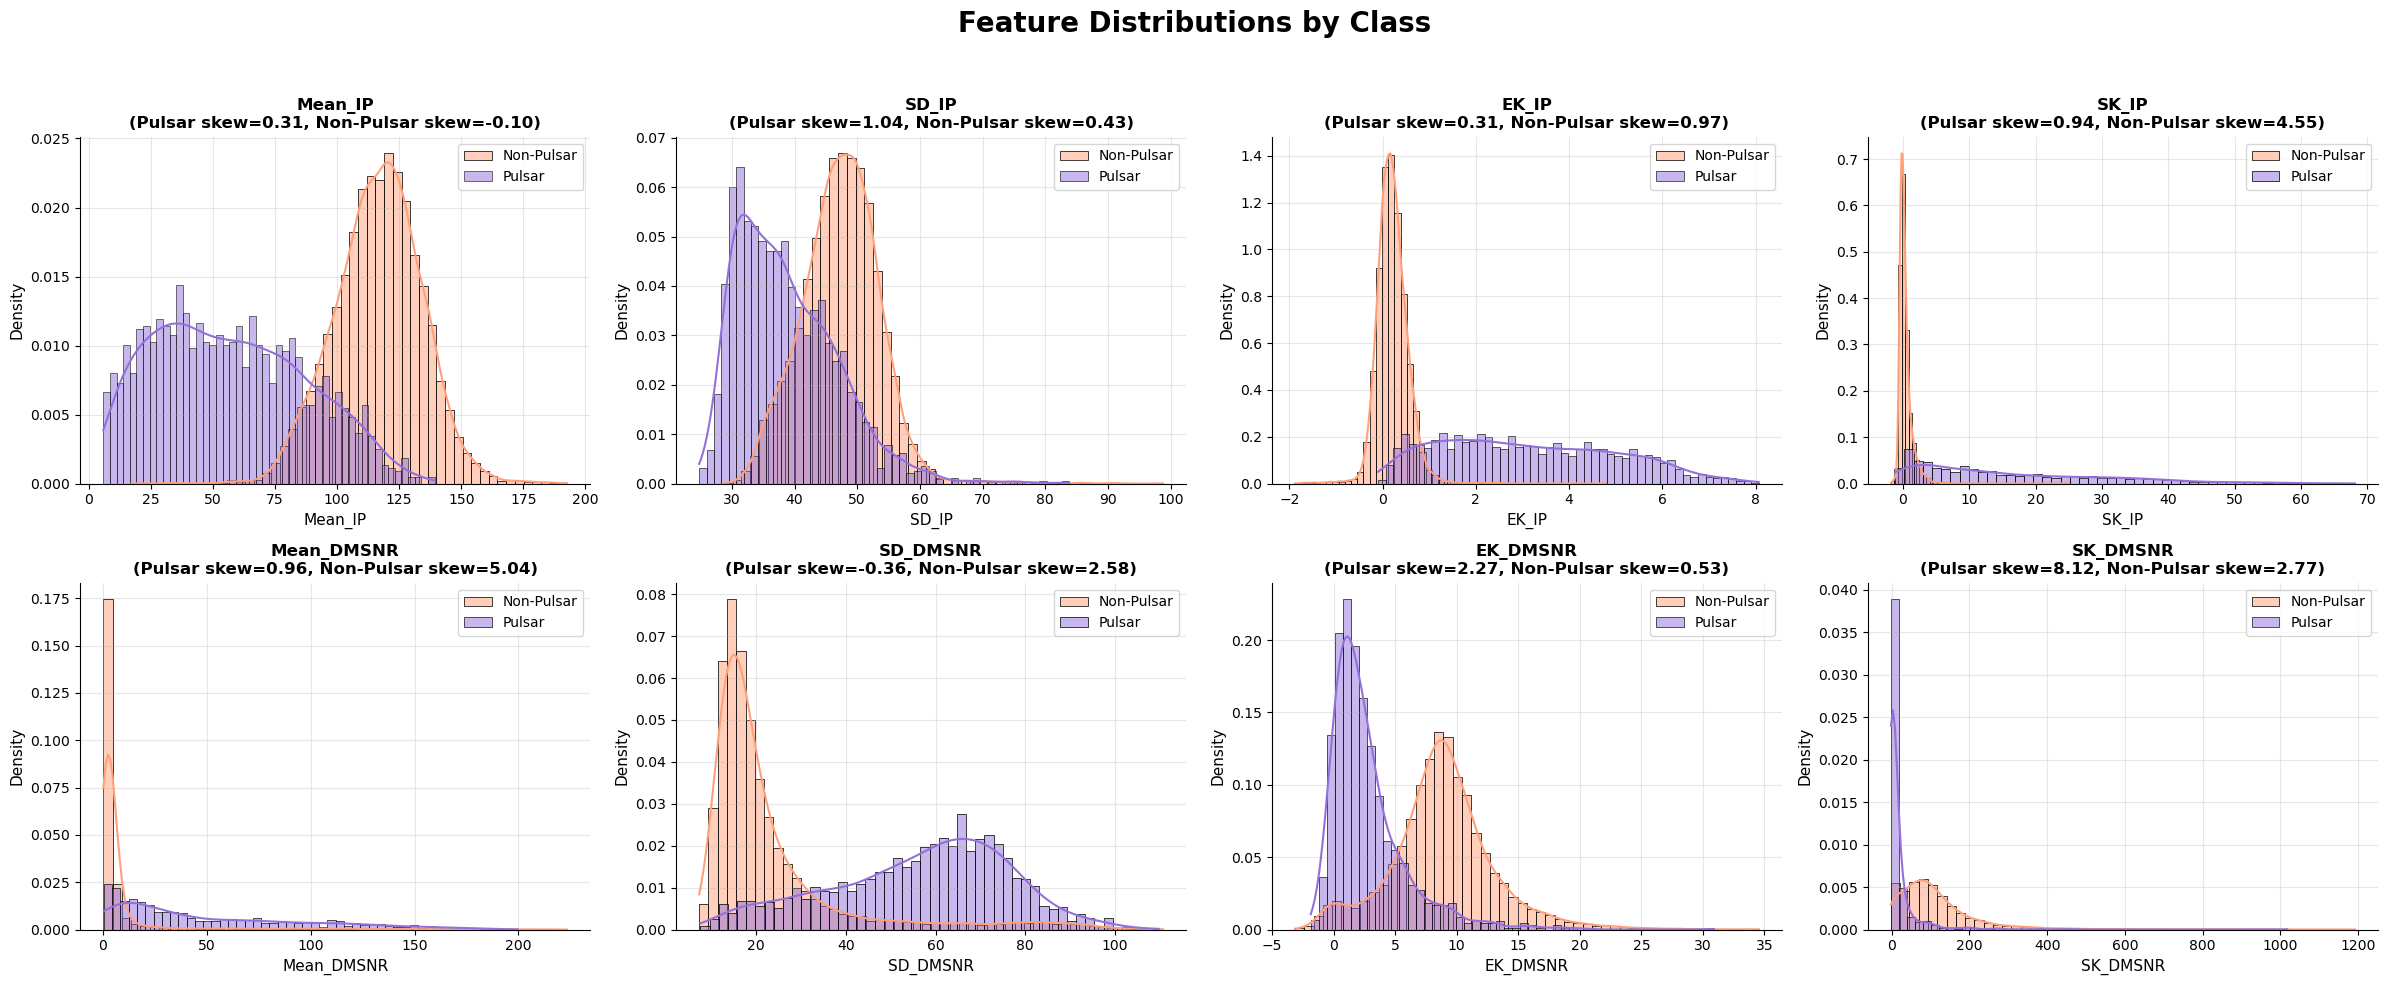

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Visualizing feature distributions by class...")

pulsar_df = pulsar[pulsar['Target_Class'] == 1]
non_pulsar_df = pulsar[pulsar['Target_Class'] == 0]

fig, axes = plt.subplots(2, 4, figsize=(24, 10))
fig.suptitle("Feature Distributions by Class", fontsize=20, fontweight='bold')

axes_flat = axes.flatten()

for i, feature in enumerate(features):
    pulsar_skew = pulsar_df[feature].skew()
    non_pulsar_skew = non_pulsar_df[feature].skew()

    sns.histplot(non_pulsar_df[feature], bins=50, kde=True, color='lightsalmon',
                 label='Non-Pulsar', ax=axes_flat[i], stat='density', alpha=0.5)

    sns.histplot(pulsar_df[feature], bins=50, kde=True, color='mediumpurple',
                 label='Pulsar', ax=axes_flat[i], stat='density', alpha=0.5)

    axes_flat[i].set_title(
        f"{feature}\n(Pulsar skew={pulsar_skew:.2f}, Non-Pulsar skew={non_pulsar_skew:.2f})",
        fontsize=12, weight='bold'
    )
    axes_flat[i].set_xlabel(feature, fontsize=11)
    axes_flat[i].set_ylabel("Density", fontsize=11)
    axes_flat[i].grid(True, alpha=0.3)
    axes_flat[i].legend(fontsize=10)

    sns.despine(ax=axes_flat[i])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../reports/figures/features_distribution_by_class.png", dpi=300, bbox_inches='tight')
plt.show()

Key takeaways:
- Most features show a clear separation
- SD_IP and EK_DMSNR have medium overlap
- All features seems useful for our classification

----
# 7. Correlation Analysis

----
For creating new features from existing features the correlation between each features is useful. In this section we will:
- Compute correlation matrix
- Visualize with heatmap
- Analyze the correlation
- Extract key insights

Analyzing correlation of features...


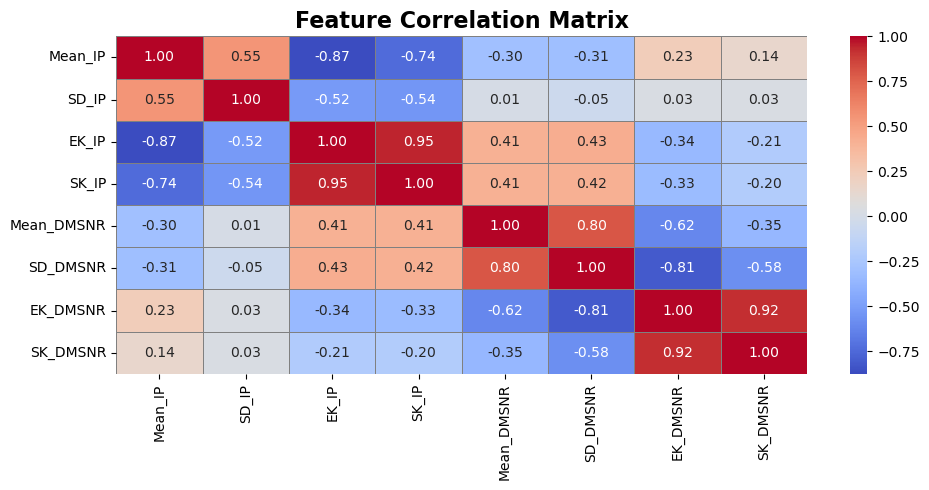

In [9]:
print("Analyzing correlation of features...")
corr_mat = pulsar[features].corr()
plt.figure(figsize = (10, 5))
sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=False,
           linewidths=0.5, linecolor='gray', annot_kws={"size": 10})
plt.title("Feature Correlation Matrix", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("../reports/figures/feature_correlation_matrix.png", dpi = 300, bbox_inches = 'tight')
plt.show()

key takeaways:
- EK (Excess Kurtosis) and SK (Skewness) are nearly redundant within each group
- Mean_IP negatively correlates with EK_IP (-0.87) and SK_IP (-0.74)
- IP vs DMSNR features have weak correlations

----
# 8. Outlier Detection

----
Before feeding the data to our model we have to know if there are any outliers and ways to handle them. So In this section we will:
- Plot a box plot for each features
- Count outliers
- Extract key insights


Visualizing box plots...


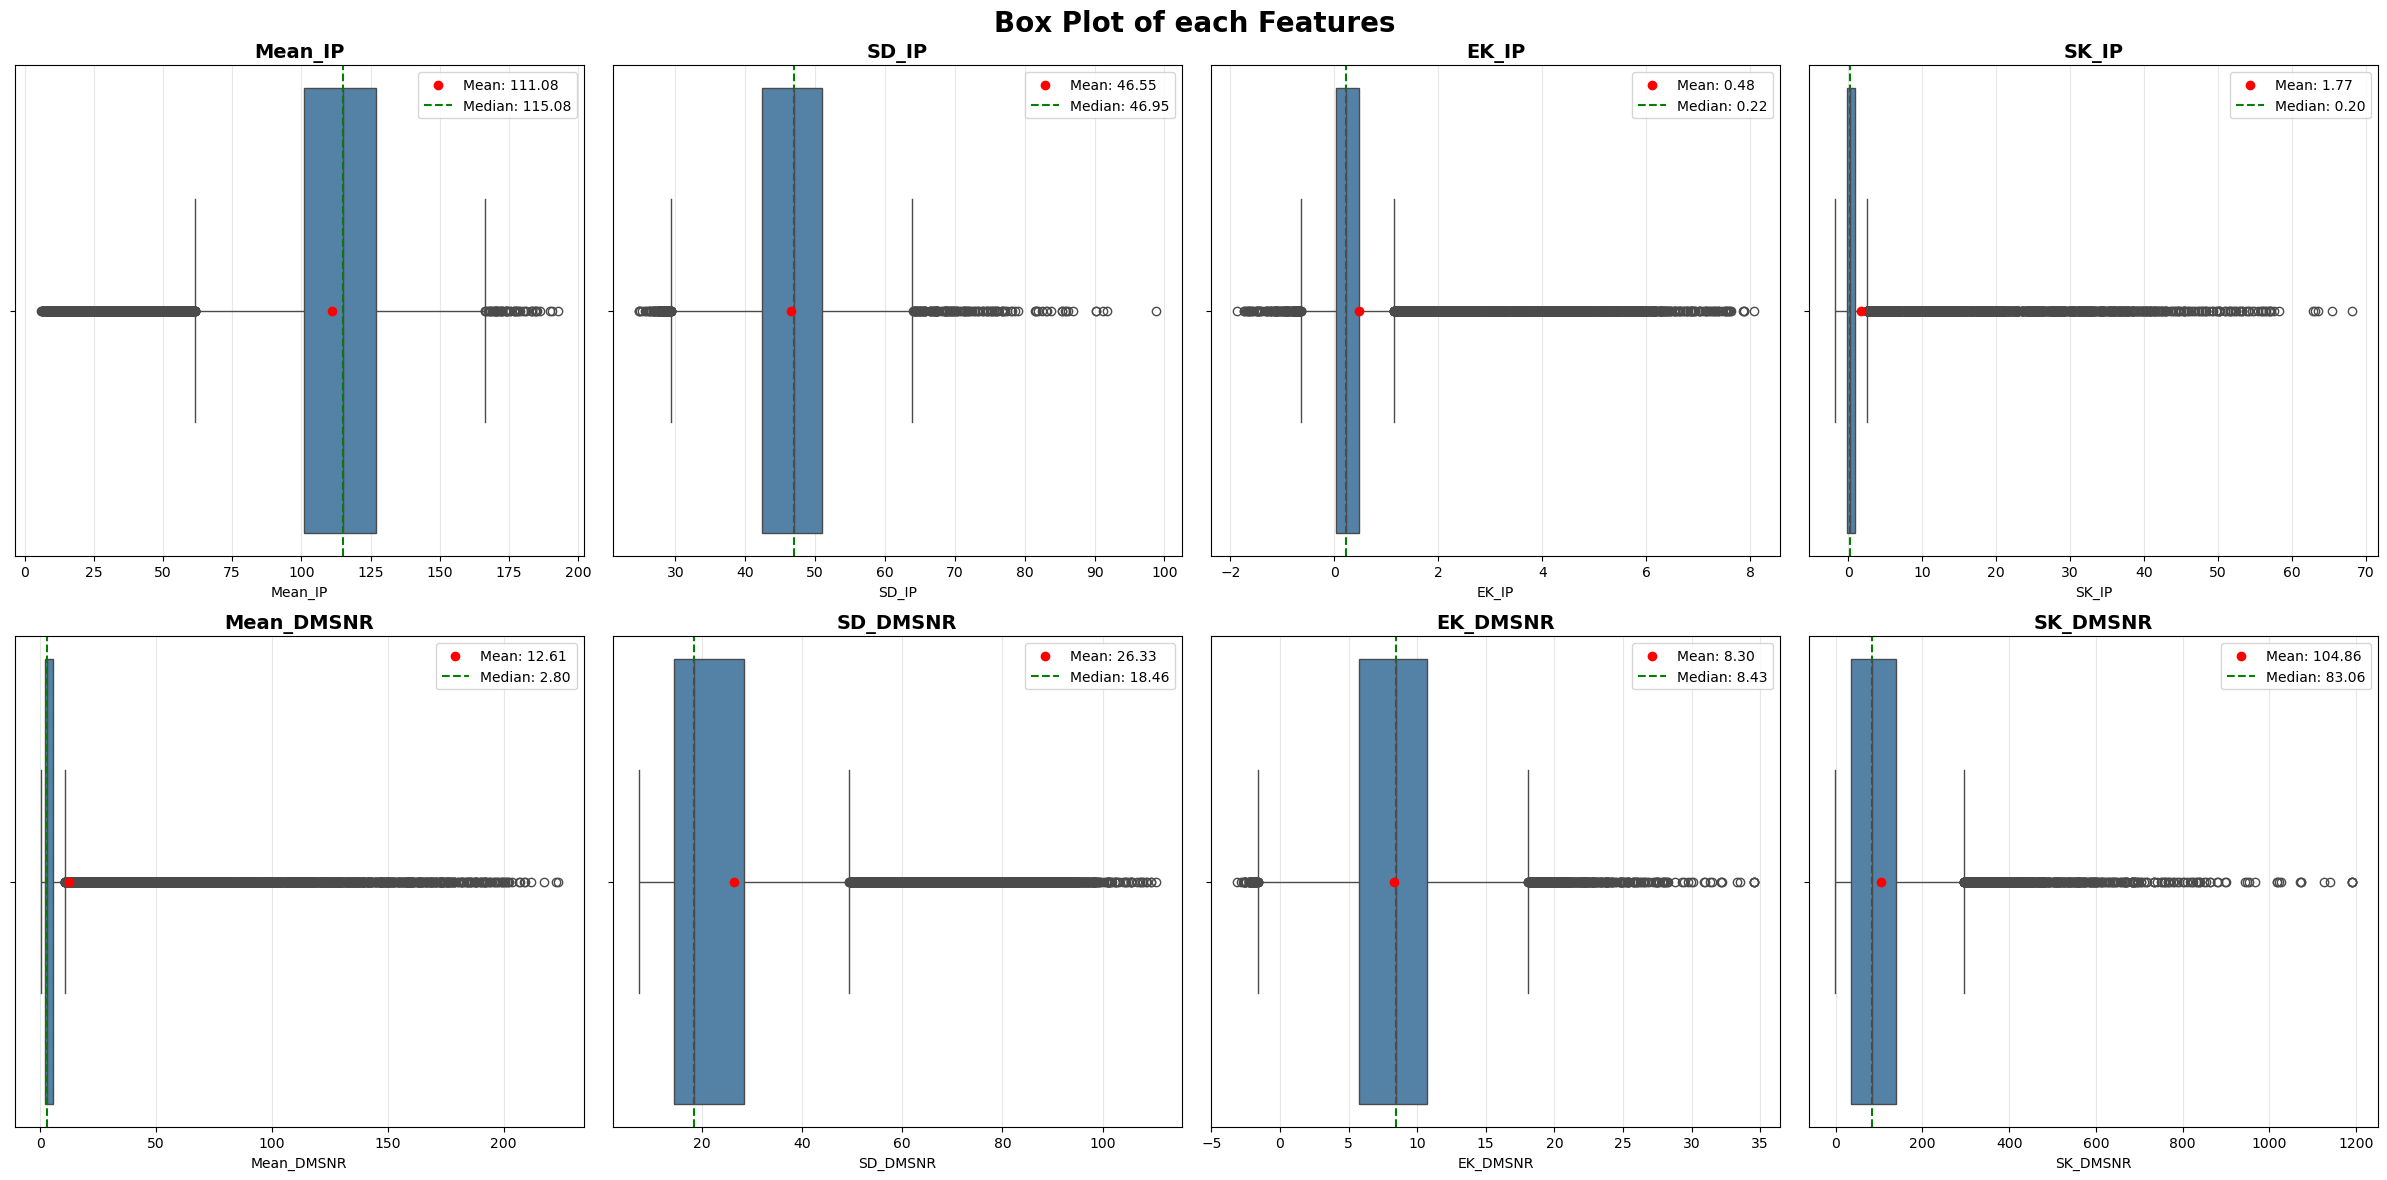

In [10]:
print("Visualizing box plots...")

fig, axes = plt.subplots(2, 4, figsize=(24, 12))
fig.suptitle("Box Plot of each Features", fontsize=20, fontweight='bold')

axes_flat = axes.flatten()
for i, feature in enumerate(features):
    sns.boxplot(pulsar, x = feature, ax = axes_flat[i], color = 'steelblue')
    mean = pulsar[feature].mean()
    median = pulsar[feature].median()

    axes_flat[i].scatter(mean, 0, color = 'red', zorder = 10, label = f"Mean: {mean:.2f}")
    axes_flat[i].axvline(median, color = 'green', linestyle = '--', label = f"Median: {median:.2f}")

    axes_flat[i].set_title(f"{feature}", fontsize=14, weight='bold')
    axes_flat[i].grid(True, axis='x', alpha=0.3)
    axes_flat[i].legend()

plt.tight_layout()
plt.savefig("../reports/figures/box_plots_for_each_features.png", dpi = 300, bbox_inches = 'tight')

In [11]:
print("Counting outliers...")

# Overall per-feature outlier counts 
outlier_dict = {}
for feature in features:
    q1, q3 = pulsar[feature].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    mask = (pulsar[feature] < lower) | (pulsar[feature] > upper)
    outlier_dict[feature] = mask.sum()

outliers_df = (
    pd.DataFrame.from_dict(outlier_dict, orient="index", columns=["Outlier Count"])
    .sort_values(by="Outlier Count", ascending=False)
)
print(outliers_df)

# Outliers by class 
print("\nOutliers by class")
pulsar_df = pulsar[pulsar["Target_Class"] == 1]
non_pulsar_df = pulsar[pulsar["Target_Class"] == 0]

outlier_by_class_dict = {}
for feature in features:
    # Pulsar
    pq1, pq3 = pulsar_df[feature].quantile([0.25, 0.75])
    piqr = pq3 - pq1
    plower, pupper = pq1 - 1.5 * piqr, pq3 + 1.5 * piqr
    pulsar_outliers = ((pulsar_df[feature] < plower) | (pulsar_df[feature] > pupper)).sum()
    pulsar_pct = pulsar_outliers / len(pulsar_df) * 100 if len(pulsar_df) else 0.0

    # Non-pulsar
    nq1, nq3 = non_pulsar_df[feature].quantile([0.25, 0.75])
    niqr = nq3 - nq1
    nlower, nupper = nq1 - 1.5 * niqr, nq3 + 1.5 * niqr
    non_pulsar_outliers = ((non_pulsar_df[feature] < nlower) | (non_pulsar_df[feature] > nupper)).sum()
    non_pulsar_pct = non_pulsar_outliers / len(non_pulsar_df) * 100 if len(non_pulsar_df) else 0.0

    outlier_by_class_dict[feature] = {
        "Pulsar": pulsar_outliers,
        "Non-Pulsar": non_pulsar_outliers,
        "Pulsar (%)": pulsar_pct,
        "Non-Pulsar (%)": non_pulsar_pct
    }

outliers_by_class_df = (pd.DataFrame(outlier_by_class_dict).T.sort_values(by="Pulsar", ascending=False))
print(outliers_by_class_df.round(2))

print("\nOutliers by rows")
# Overall unique rows that have at least one outlier (any feature)
global_mask = pd.Series(False, index=pulsar.index)
for feature in features:
    q1, q3 = pulsar[feature].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    global_mask |= (pulsar[feature] < lower) | (pulsar[feature] > upper)

total_unique_outlier_rows = int(global_mask.sum())
total_unique_outlier_pct = total_unique_outlier_rows / len(pulsar) * 100

# Per-class unique rows that have at least one outlier 
pulsar_mask = pd.Series(False, index=pulsar_df.index)
non_pulsar_mask = pd.Series(False, index=non_pulsar_df.index)

for feature in features:
    # pulsar class mask
    pq1, pq3 = pulsar_df[feature].quantile([0.25, 0.75])
    piqr = pq3 - pq1
    plower, pupper = pq1 - 1.5 * piqr, pq3 + 1.5 * piqr
    pulsar_mask |= (pulsar_df[feature] < plower) | (pulsar_df[feature] > pupper)

    # non-pulsar class mask
    nq1, nq3 = non_pulsar_df[feature].quantile([0.25, 0.75])
    niqr = nq3 - nq1
    nlower, nupper = nq1 - 1.5 * niqr, nq3 + 1.5 * niqr
    non_pulsar_mask |= (non_pulsar_df[feature] < nlower) | (non_pulsar_df[feature] > nupper)

pulsar_unique_rows = int(pulsar_mask.sum())
non_pulsar_unique_rows = int(non_pulsar_mask.sum())
pulsar_unique_pct = pulsar_unique_rows / len(pulsar_df) * 100 if len(pulsar_df) else 0.0
non_pulsar_unique_pct = non_pulsar_unique_rows / len(non_pulsar_df) * 100 if len(non_pulsar_df) else 0.0

total_outliers = pd.DataFrame({
    "Count": [pulsar_unique_rows, non_pulsar_unique_rows, total_unique_outlier_rows],
    "Percentage (%)": [pulsar_unique_pct, non_pulsar_unique_pct, total_unique_outlier_pct]
}, index=["Pulsar", "Non-Pulsar", "Overall"])

print(total_outliers.round(2))

# Rows with >=2 feature outliers (shows heavily corrupted rows)
flag_df = pd.DataFrame(False, index=pulsar.index, columns=features)
for feature in features:
    q1, q3 = pulsar[feature].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    flag_df[feature] = (pulsar[feature] < lower) | (pulsar[feature] > upper)

# counts of rows with >=2 flagged features
multi_flag_rows = (flag_df.sum(axis=1) >= 2).sum()
multi_flag_rows_pct = multi_flag_rows / len(pulsar) * 100

# by class
multi_flag_pulsar = (flag_df.loc[pulsar_df.index].sum(axis=1) >= 2).sum()
multi_flag_non_pulsar = (flag_df.loc[non_pulsar_df.index].sum(axis=1) >= 2).sum()

print("\nRows with >=2 feature outliers (global / pulsar / non-pulsar):")
print(f"{multi_flag_rows} ({multi_flag_rows_pct:.2f}%), {multi_flag_pulsar}, {multi_flag_non_pulsar}")

Counting outliers...
            Outlier Count
Mean_DMSNR           2927
SD_DMSNR             2346
SK_IP                1901
EK_IP                1596
Mean_IP              1030
SK_DMSNR              901
EK_DMSNR              487
SD_IP                 262

Outliers by class
            Pulsar  Non-Pulsar  Pulsar (%)  Non-Pulsar (%)
SK_DMSNR     212.0       908.0       12.93            5.58
EK_DMSNR     104.0       999.0        6.35            6.14
SD_IP         21.0       150.0        1.28            0.92
SK_IP         12.0      1078.0        0.73            6.63
Mean_DMSNR     8.0      2118.0        0.49           13.03
Mean_IP        0.0       142.0        0.00            0.87
EK_IP          0.0       392.0        0.00            2.41
SD_DMSNR       0.0      1668.0        0.00           10.26

Outliers by rows
            Count  Percentage (%)
Pulsar        252           15.38
Non-Pulsar   4004           24.63
Overall      4578           25.58

Rows with >=2 feature outliers (global /

Key tekeaways:
- All features have overall outliers
- Mean_DMSNR, SD_DMSNR, SK_IP, EK_IP, Mean_IP have more than 1,000 outliers
- Both classes have outliers in SK_DMSNR, EK_DMSNR, SD_IP, SK_IP, Mean_DMSNR 
    

----
# 9. Key Insights & Takeaways

----

**1. Data Quality**
- 17,898 samples, 8 features, 1 target
- No missing values
- No duplicates
- Clean column names

**2. Class Imbalance**
- Severe imbalance: 91% non-pulsar, 9% pulsar
- Imbalance ratio: 0.10
- *Action needed*: Class weighting or SMOTE

**3. Feature Quality**  
*Top discriminative features:*
1. Mean_IP (excellent separation)
2. SD_DMSNR (bimodal distribution)
3. EK_DMSNR (strong signal)

*Moderate features:*
- Mean_DMSNR, SK_IP, SD_IP

*Weaker features:*
- EK_IP, SK_DMSNR (still useful)

**4. Correlations**
- High multicollinearity: EK_IP - SK_IP (0.95), EK_DMSNR - SK_DMSNR (0.92)
- IP and DMSNR groups are complementary
- *Action*: Use L2 regularization to handle multicollinearity

**5. Distributions**
- Most features heavily right-skewed
- SD_IP and EK_DMSNR near-normal
- *Action*: StandardScaler for normalization

**6. Outliers**  
**Outlier Prevalence**
- *Overall*: 25.58% of samples have outliers in at least one feature
- *Most outlier-prone*: Mean_DMSNR (2,927), SD_DMSNR (2,346)
- *Least outlier-prone*: SD_IP (262), EK_DMSNR (487)

**Class-Specific Patterns**
- *Non-pulsars*: More outliers overall (24.63% vs 15.38%)
- *Feature-specific*:
  - SD_DMSNR, EK_IP outliers: 100% non-pulsar
  - SK_DMSNR outliers: 12.93% pulsar (higher than non-pulsar 5.58%)
- *Implication*: Outliers are INFORMATIVE, not noise!

**Decision**
*KEEP ALL OUTLIERS* because:
- They help distinguish classes
- Real-world data will have similar patterns 

**7. Preprocessing Needs**
1. Feature scaling (StandardScaler) - MANDATORY
2. Class imbalance handling (class weights)
3. Train/val/test split (stratified)